# Point Spread Function Photometry with Photutils

The PSF photometry module of photutils is intended to be a fully modular tool such that users are able to completly customise the photometry procedure, e.g., by using different source detection algorithms, background estimators, PSF models, etc. Photutils provides implementations for each subtask involved in the photometry process, however, users are still able to include their own implementations without having to touch into the photutils core classes!

This modularity characteristic is accomplished by using the object oriented programming approach which provides a more convient user experience while at the same time allows the developers to think in terms of classes and objects rather than isolated functions.

Photutils provides three basic classes to perform PSF photometry: `BasicPSFPhotometry`, `IterativelySubtractedPSFPhotometry`, and `DAOPhotPSFPhotometry`. In this notebook, we will go through them, explaining their differences and particular uses.

# Artificial Starlist

First things first! Let's create an artifical list of stars using photutils in order to explain the PSF procedures through examples.

In [1]:
from photutils.datasets import make_random_gaussians_table
from photutils.datasets import make_noise_image
from photutils.datasets import make_gaussian_sources_image
import numpy as np

num_sources = 150
min_flux = 500
max_flux = 5000
min_xmean = 16
max_xmean = 240
sigma_psf = 2.0

param_ranges = dict([('flux', [500, 1000]),
                ('x_mean', [min_xmean, max_xmean]),
                ('y_mean', [min_xmean, max_xmean]),
                ('x_stddev', [sigma_psf, sigma_psf]),
                ('y_stddev', [sigma_psf, sigma_psf]),
                ('theta', [0, np.pi])])
starlist = make_random_gaussians_table(num_sources, param_ranges,
                                       random_state=1234)

shape = (256, 256)
image = (make_gaussian_sources_image(shape, starlist) +
         make_noise_image(shape, type='poisson', mean=6., random_state=1234) + 
         make_noise_image(shape, type='gaussian', mean=0., stddev=2., random_state=1234))

Note that we also added Poisson and Gaussian background noises with the function `make_noise_image`.

Let's keep in mind this fact:

In [2]:
type(starlist)

astropy.table.table.Table

In [3]:
starlist

x_stddev,flux,x_mean,theta,y_stddev,y_mean,amplitude
float64,float64,float64,float64,float64,float64,float64
2.0,987.2475690436299,80.03659883065902,1.781538177411021,2.0,201.20499063758612,39.28133266718773
2.0,833.8934530725188,237.03137623568168,2.5709065626185863,2.0,100.22778419457705,33.179566267115206
2.0,627.8266432170699,112.72339006196705,2.949915615452562,2.0,152.45565380805,24.98042841819711
2.0,554.1557470913644,144.62850868740642,0.6060176678049132,2.0,154.8848287054856,22.049156598093212
2.0,888.0903615869411,134.10222517502757,2.239465549872561,2.0,114.89599325992813,35.33599273970759
2.0,891.238996300101,60.27428306056285,2.1926425616500493,2.0,60.5249045500489,35.46127293435512
2.0,880.801957153747,53.11868881836284,0.811462382775713,2.0,115.44561108463373,35.04599634150866
2.0,957.2015566346619,128.22186257457247,2.877095118052727,2.0,223.1478851281126,38.08583981841581
2.0,829.3113909712113,237.8057094591104,1.6724525680292062,2.0,166.40129657424225,32.99725180887093


Pretty much all lists of sources in `photutils` are returned or passed in as `astropy` `Table` objects, so this is something to get used to.

Let's also plot an image of our simulated stars.

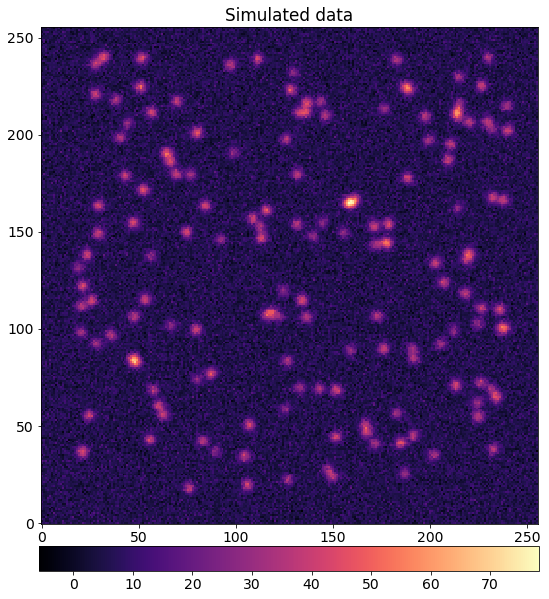

In [4]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['image.cmap'] = 'magma'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (20,10)
rcParams['image.interpolation'] = 'nearest'
rcParams['image.origin'] = 'lower'
rcParams['font.size'] = 14

plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

# The `BasicPSFPhotometry` class

As the name suggests, this is a basic class which provides the minimum tools necessary to perform photometry in crowded fields (or non crowded fields). Let's take a look into its attributes and methods.

BasicPSFPhotometry has the following mandatory attributes:
    * group_maker : callable or instance of any GroupStarsBase subclass
    * bkg_estimator : callable, instance of any BackgroundBase subclass, or None
    * psf_model : astropy.modeling.Fittable2DModel instance
    * fitshape : integer or length-2 array-like

And the following optional attributes:
    * finder : callable or instance of any StarFinderBase subclasses or None
    * fitter : Astropy Fitter instance
    * aperture_radius : float or int

## Group Maker

`group_maker` can be instantiated using any GroupStarBase subclass, such as `photutils.psf.DAOGroup` or `photutils.psf.DBSCANGroup`, or even using a `callable` provided by the user.

`photutils.psf.DAOGroup` is a class which implements the `GROUP` algorithm proposed by Stetson which is used in DAOPHOT. This class takes one attribute to be initialized namely:
    * crit_separation : int or float
    Distance, in units of pixels, such that any two stars separated by less than this distance will be placed in the same group.

As it is shown in its description, `crit_separation` plays a crucial role in deciding whether or not a given star belong to some group of stars. Usually, `crit_separation` is set to be a positive real number multiplied by the FWHM of the PSF.

`photutils.psf.DBSCANGroup` is a generalized case of `photutils.psf.DAOGroup`, in fact, it is a wrapper around the `sklearn.cluster.DBSCAN` class. Its usage is very similar to `photutils.psf.DAOGroup` and we refer the photutils API doc page for more information: https://photutils.readthedocs.io/en/stable/api/photutils.psf.DBSCANGroup.html#photutils.psf.DBSCANGroup

The user is welcome to check the narrative docs on the photutils RTD webpage: https://photutils.readthedocs.io/en/stable/grouping.html

Now, let's instantiate a `group_maker` from `DAOGroup`:

In [5]:
from photutils import psf
from astropy.stats import gaussian_sigma_to_fwhm

In [6]:
daogroup = psf.DAOGroup(crit_separation=2.*sigma_psf*gaussian_sigma_to_fwhm)

Now, the object `daogroup` is ready to be passed to `BasicPSFPhotometry`.

## Background Estimation

Background estimation is needed in the photometry process in order to reduce the bias added primarily by Poisson noise background into the flux estimation.

Photutils provides several classes to perform both scalar background estimation, i.e., when the background is flat and does not vary strongly across the image, and spatial varying background estimation, i.e., when there exists a gradient field associated with the background.

The user is welcome to refer to the Background Esimation narrative docs in the photutils webpage for a detailed explanation. https://photutils.readthedocs.io/en/stable/background.html

In this notebook, we will use the class `MMMBackground` which is intended to estimate scalar background. This class is based on the background estimator used in `DAOPHOT`.

`MMMBackground` gets a `SigmaClip` object as an attribute. It's basically used to perform sigma clip on the image before performing background estimation. For our scenario, we will just instatiate a object of `MMMBackground` with default attribute values:

In [7]:
from photutils import MMMBackground
mmm_bkg = MMMBackground()

In [8]:
mmm_bkg.sigma_clip.sigma

3.0

In [9]:
mmm_bkg.sigma_clip.maxiters

5

## PSF Models

The attribute ``psf_model`` represents an analytical function with unknown parameters (e.g., peak center and flux) which describes the underlying point spread function. ``psf_model`` is usually a subclass of `astropy.modeling.Fittable2DModel`. In this notebook, we will use `photutils.psf.IntegratedGaussianPRF` as our underlying PSF model.

Note that the underlying PSF model has to have parameters with the following names ``x_0``, ``y_0``, and ``flux``, to describe the center peak position and the flux, respectively.

In [10]:
from photutils.psf import IntegratedGaussianPRF
gaussian_psf = IntegratedGaussianPRF(sigma=2.0)

## Finder

Finder is an optional attribute, meaning that if it is `None`, then the user should provide a table with the center positions of each star when calling the `BasicPSFPhotometry` object.
Later, we will see examples of both cases, i.e., when Finder is `None` and when it is not.

The finder attribute is used to perform source detection. It can be any subclass of `photutils.StarFinderBase` such as `photutils.DAOStarFinder` or `photutils.IRAFStarFinder`, which implement a DAOPHOT-like or IRAF-like source detection algorithms, respectively. The user can also set her/his own source detection algorithm as long as the input/output formats are compatible with `photutils.StarFinderBase`.

`photutils.DAOStarFinder`, for instance, receives the following mandatory attributes: 
    * threshold : float
        The absolute image value above which to select sources.
    * fwhm : float
        The full-width half-maximum (FWHM) of the major axis of the Gaussian kernel in units of pixels.

Now, let's instantiate our `DAOStarFinder` object:

In [11]:
from photutils.detection import DAOStarFinder

daofinder = DAOStarFinder(threshold=2.5*mmm_bkg(image), fwhm=sigma_psf*gaussian_sigma_to_fwhm)

Note that we choose the `threshold` to be a multiple of the background level and we assumed the `fwhm` to be known from our list of stars.

More details about source detection can be found on the `photutils.detection` narrative docs: https://photutils.readthedocs.io/en/stable/detection.html

## Fitter

Fitter should be an instance of a fitter implemented in `astropy.modeling.fitting`. Since the PSF model is almost always nonlinear, the fitter should be able to handle nonlinear optimization problems. In this notebook, we will use the `LevMarLSQFitter`, which combines the Levenberg-Marquardt optimization algorithm with the least-squares statistic. The default value for fitter is `LevMarLSQFitter()`.  

Look at http://docs.astropy.org/en/stable/modeling/index.html for more details on fitting.

NOTE: At this point it should be stated that photutils does not have a standard way to compute uncertainties on the fitted parameters. However, this will change in the near future with the addition of a new affiliated package to the Astropy environment, namely, `SABA: Sherpa-Astropy Bridge` which made possible to use astropy models together with Sherpa Fitters.

## Fitshape and Aperture Radius

There are two attributes left: `fitshape` (mandatory) and `aperture_radius` (optional).
`fitshape` corresponds to the size of the rectangular region necessary to enclose one single source. The pixels inside that region will be used in the fitting process. `fitshape` should be an odd integer or a tuple of odd integers.

In [12]:
fitshape = 11

The aperture radius corresponds to the radius used to compute initial guesses for the fluxes of the sources. If this value is `None`, then one fwhm will be used if it can be determined by the `psf_model`.

## Example with unknown positions and unknown fluxes

Now we are ready to take a look at an actual example. Let's first create our `BasicPSFPhotometry` object putting together the pieces that we defined along the way:

In [13]:
from photutils.psf import BasicPSFPhotometry
basic_photometry = BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg,
                                      psf_model=gaussian_psf, fitshape=fitshape,
                                      finder=daofinder)

To actually perform photometry on our image that we defined previously, we should use `basic_photometry` as a function call:

In [14]:
photometry_results = basic_photometry(image)
photometry_results

x_0,y_0,flux_0,id,group_id,flux_fit,x_fit,y_fit,y_0_unc,flux_unc,x_0_unc
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
75.89358527124908,17.939589822849136,765.3885759593156,1,1,829.9485768948196,75.8647627786433,18.037153918689285,0.08188896567920072,23.76339931686155,0.08189209559237803
105.72289932957011,19.651214580108295,797.6502244895155,2,2,872.0610757238675,105.73851513361399,19.56518729414954,0.07620848772835315,23.226495142289277,0.07618530259861557
126.78826745389493,22.31635970245072,616.0307963718046,3,3,677.7028621302987,126.75126578324755,22.266170522419152,0.09975185441984545,23.633119649866494,0.09974915215607427
186.9299436640218,25.382278258052338,589.8926314770193,4,4,634.6142275227228,186.8388139902918,25.49246230625516,0.09817883629113468,21.772019010904643,0.09812539608806442
148.63744056524203,24.982826781000945,1078.975118560383,5,5,1013.9209565270095,148.88211161913978,25.33638708758103,0.13062053557712447,46.29473458277279,0.13058949626761768
104.2694934266451,34.52412474272099,784.1157822402838,6,6,824.231744966851,104.3026810119315,34.484170417177516,0.08259217154027593,23.786712858276424,0.08255669400675507
201.9557222805132,35.12393212725744,618.2384061002253,7,7,690.4311762411579,201.91659484302892,35.05809806605519,0.0960496626428026,23.187256989620504,0.09605164493078201
20.792896615817845,36.69700145769714,952.2610735049994,8,8,1003.0178048263709,20.752017953413525,36.61075871022977,0.06859879933338202,24.049191197274148,0.06858371793343472
89.2113071452244,36.83365060782131,481.819710669537,9,9,507.0599279013978,89.37568432732341,36.80389014925974,0.12817843894607198,22.691112527020888,0.1283004940104738


Let's plot the residual image along with the original image:

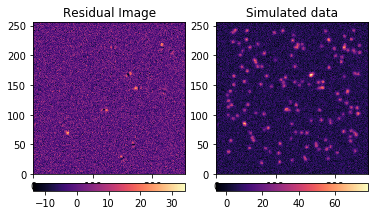

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.imshow(basic_photometry.get_residual_image())
ax1.set_title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04,
             ax=ax1, mappable=im1)

im2 = ax2.imshow(image)
ax2.set_title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04,
             ax=ax2, mappable=im2)

Looking at the residual image we observe that the photometry process was able to fit many stars but not all. This is probably due to inability of the source detection algorithm to decide the number of sources in every crowded group. Therefore, let's play with the source detection classes to see whether we can improve the photometry process.

Let's use the `IRAFStarFinder` and play with the optional parameters. A complete description of these parameters can be seen at the `photutils.dection` API documentation: https://photutils.readthedocs.io/en/stable/api/photutils.detection.IRAFStarFinder.html#photutils.detection.IRAFStarFinder

In [16]:
from photutils.detection import IRAFStarFinder
iraffind = IRAFStarFinder(threshold=2.5*mmm_bkg(image),
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)

Now let's set the `finder` attribute of our `BasicPSFPhotometry` object with `iraffind`:

In [17]:
basic_photometry.finder = iraffind

Let's repeat the photometry process:

In [18]:
photometry_results = basic_photometry(image)
photometry_results

x_0,y_0,flux_0,id,group_id,flux_fit,x_fit,y_fit,y_0_unc,flux_unc,x_0_unc
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
75.93215779738,17.935344650878246,765.3887052886399,1,1,829.9485341951306,75.86476072949559,18.037152113015953,0.08188896989517866,23.763399325200727,0.08189209993644336
105.82681167167233,19.386926256286717,802.1771327919105,2,2,871.7677821423914,105.73932761025576,19.568073116544042,0.07639721883550611,23.267579253009576,0.07634560811343664
126.86276271472936,22.158349679736872,618.162928090549,3,3,677.7028858356967,126.75127050517915,22.266159057549203,0.09975184927038935,23.6331196078311,0.0997491479476685
149.6116639857268,24.387945062664144,1012.3584954958962,4,4,753.9071930451961,149.8090572433918,23.914859460136878,0.12596768893832097,33.22502633226135,0.10847190918159473
148.84760829602587,25.54162032199803,1088.704421247909,6,4,618.6816093828232,147.4155127084199,27.731065869225798,0.15639991653869678,33.055195042150764,0.13433210120659947
186.8889327780214,25.298472352088673,590.8637354550373,5,5,634.615629122992,186.83871832931342,25.492566450027507,0.09817865201119767,21.77202018108634,0.09812519116779116
104.21139888263464,34.59896593197049,783.0831578486602,7,6,824.227394214023,104.30266426030376,34.484200604093466,0.08259259955216014,23.786712575688412,0.08255712670323284
202.42196415666243,35.141855828824504,606.5182214925849,8,7,690.431830351198,201.9165456536183,35.05815439745435,0.09604957183332298,23.18725666457808,0.09605155411483016
20.8117523435236,36.4549981237955,952.5865979270011,9,8,1002.6142133764649,20.754055659989607,36.6091216398717,0.06592066926221316,23.086887844665064,0.06586566783320047


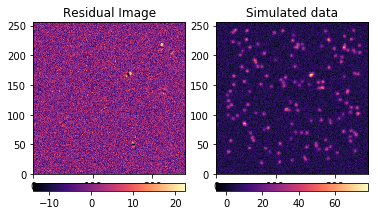

In [19]:
plt.subplot(1,2,1)
plt.imshow(basic_photometry.get_residual_image())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

As we can see, the residual presents a better Gaussianity with only three groups that were not fitted well. The reason for that is that the sources may be too close to be distinguishable by the source detection algorithm.

## Example with known positions and unknown fluxes

Let's assume that somehow we know the true positions of the stars and we only would like to perform fitting on the fluxes. Then we should use the optional argument `init_guesses` when calling the photometry object:

In [ ]:
from astropy.table import Table
positions = Table(names=['x_0', 'y_0'], data=[starlist['x_mean'], starlist['y_mean']])

In [ ]:
photometry_results = basic_photometry(image=image, init_guesses=positions)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(basic_photometry.get_residual_image())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

Let's do a scatter plot between ground-truth fluxes and estimated fluxes:

In [ ]:
photometry_results.sort('id')
plt.scatter(starlist['flux'], photometry_results['flux_fit'])
plt.xlabel('Ground-truth fluxes')
plt.ylabel('Estimated fluxes')

Let's also plot the relative error on the fluxes estimation as a function of the ground-truth fluxes.

In [ ]:
plt.scatter(starlist['flux'], (photometry_results['flux_fit'] - starlist['flux'])/starlist['flux'])
plt.xlabel('Ground-truth flux')
plt.ylabel('Estimate Relative Error')

As we can see, the relative error becomes smaller as the flux increases.

# `IterativelySubtractedPSFPhotometry`

`IterativelySubtractedPSFPhotometry` is a subclass of `BasicPSFPhotometry` which adds iteration functionality to the photometry procedure. It has the same attributes as `BasicPSFPhotometry`, except that it includes an additional `niters` which represents the number of of times to loop through the photometry process, subtracting the best-fit stars each time.

Hence, the  process implemented in `IterativelySubtractedPSFPhotometry` resembles the loop used by DAOPHOT: `FIND`, `GROUP`, `NSTAR`, `SUBTRACT`, `FIND`. On its own `IterativelySubtractedPSFPhotometry` doesn't implement the specific algorithms used in DAOPHOT, but it does implement the *structure* to enambe this (and `DAOPhotPSFPhotometry`, discussed below, does).

The attribute `niters` can be `None`, which means that the photometry procedure will continue until no more sources are detected.

One final detail: the attribute `finder` (specifying the star-finder algorithm) for `IterativelySubtractedPSFPhotometry` cannot be `None` (as it can be for `BasicPSFPhotometry`). This is because it would not make sense to have an iterative process where the star finder changes completely at each step.  If you want to do that you're better off manually looping over a series of calls to different `BasicPSFPhotometry` objects.

## Example with unknown positions and unknown fluxes

Let's instantiate an object of `IterativelySubtractedPSFPhotometry`:

In [ ]:
from photutils.psf import IterativelySubtractedPSFPhotometry
itr_phot = IterativelySubtractedPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg,
                                              psf_model=gaussian_psf, fitshape=fitshape,
                                              finder=iraffind, niters=2)

Let's now perform photometry on our artificil image:

In [ ]:
photometry_results = itr_phot(image)
photometry_results

Observe that there is a new column namely `iter_detected` which shows the number of the iteration in which that source was detected.

Let's plot the residual image:

In [ ]:
plt.subplot(1,2,1)
plt.imshow(itr_phot.get_residual_image())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

# `DAOPhotPSFPhotometry` 

There is also a class called `DAOPhotPSFPhotometry` that is a subclass of `IterativelySubtractedPSFPhotometry`.  `DAOPhotPSFPhotometry` essentially implements the DAOPHOT photometry algorithm using `IterativelySubtractedPSFPhotometry`.  So instead of giving it arguments like `finder`, you provide parameters specific for the DAOPhot-like sub-tasks (e.g., the FWHM the star-finder is optimized for).

We leave the use of this class as an exercise to the user to play with the parameters which would optimize the photometry procedure.

In [ ]:
from photutils.psf import DAOPhotPSFPhotometry

dao_phot = DAOPhotPSFPhotometry(...)

photometry_results = dao_phot(image)
photometry_results

## Documentation

Narrative and API docs of the classes used here can be found in https://photutils.readthedocs.io/en/stable/

# Future Works
The PSF Photometry module in photutils is still under development and feedback from users is much appreciated. Please open an issue on the github issue tracker of photutils with any suggestions for improvement, functionalities wanted, bugs, etc. 

Near future implementations in the photutils.psf module include:

* FWHM estimation: a Python equivalent to DAOPHOT psfmeasure.
* Uncertainties computation: uncertainties are very critical and it's very likely that we are going to use astropy saba package to integrate uncertainty computation into photutils.psf.